# 1. Vocab(kowiki) -> tensor

In [2]:
import sentencepiece as spm
# vocab loading
vocab_file = "kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# input text
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text to tensor (토크나이징)
import torch
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line) # 문장을 토큰으로 나
  ids = vocab.encode_as_ids(line) #  토큰을 ID로 인코딩
  inputs.append(torch.tensor(ids)) # convert
  print(pieces)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']


### Padding?
자연어 처리를 하다보면 각 문장(또는 문서)은 서로 길이가 다를 수 있습니다. 그런데 기계는 길이가 전부 동일한 문서들에 대해서는 하나의 행렬로 보고, 한꺼번에 묶어서 처리할 수 있습니다. 다시 말해 병렬 연산을 위해서 여러 문장의 길이를 임의로 동일하게 맞춰주는 작업이 필요할 때가 있습니다.

https://wikidocs.net/83544

### batch_first?
batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정 (Default: False)

예시)

batch_first=False라면, (Time_step, Batch_size, Input_feature_dimension) 순서이다.
batch_first=True라면, (Batch_size, Time_step, Input_feature_dimension) 순서이다.

In [3]:
# torch.nn.utils.rnn.pad_sequence, 주어진 텐서의 리스트를 패딩된 하나의 텐서로 만들어줌
# padding? 시퀀스 길이 동일하게 맞추기 위해 *값으로 채우는 작업 -> 여기선 0
# (길이가 짧은 시퀀스에 0으로 채워져서 모든 시퀀스가 동일한 길이를 갖게)
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
                                                # 미니 배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지 여부
                                                                   # 패딩에 사용할 값, 0으로 설정

# shape
print(inputs.size())
# 값
print(inputs)

torch.Size([2, 8])
tensor([[3225, 3658,  199, 4011, 3811, 3644,    0,    0],
        [ 193, 3660,   54, 3889, 3650, 3736, 3811, 3644]])


# 2. Embedding

## 2.1 input embedding : 입력 토큰을 vector 형태로 변환

In [4]:
import torch.nn as nn
n_vocab = len(vocab)
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # create embedding layer (d_hidn as the size of each embedding vector (hidden size))

input_embs = nn_emb(inputs) # apply embedding layer to the paddd tensor
print(input_embs.size()) # after embedding layer

torch.Size([2, 8, 128])


## 2.2 positionvembedding

#### Positional encoding의 조건

1) 각 Time-step마다 고유의 Encoding 값을 출력해야 한다.

2) 서로 다른 Time-step이라도 같은 거리라면 차이가 일정해야 한다.

3) 순서를 나타내는 값이 특정 범위 내에서 일반화가 가능해야 한다.

4) 같은 위치라면 언제든 같은 값을 출력해야 한다.

### 방법
1) 각 position별 angle 값을 구합니다.

2) 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구합니다.

3) 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구합니다.

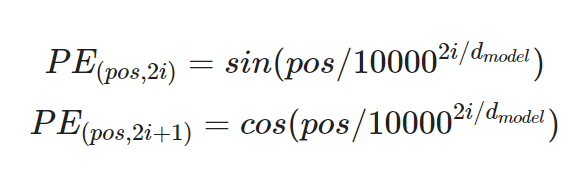

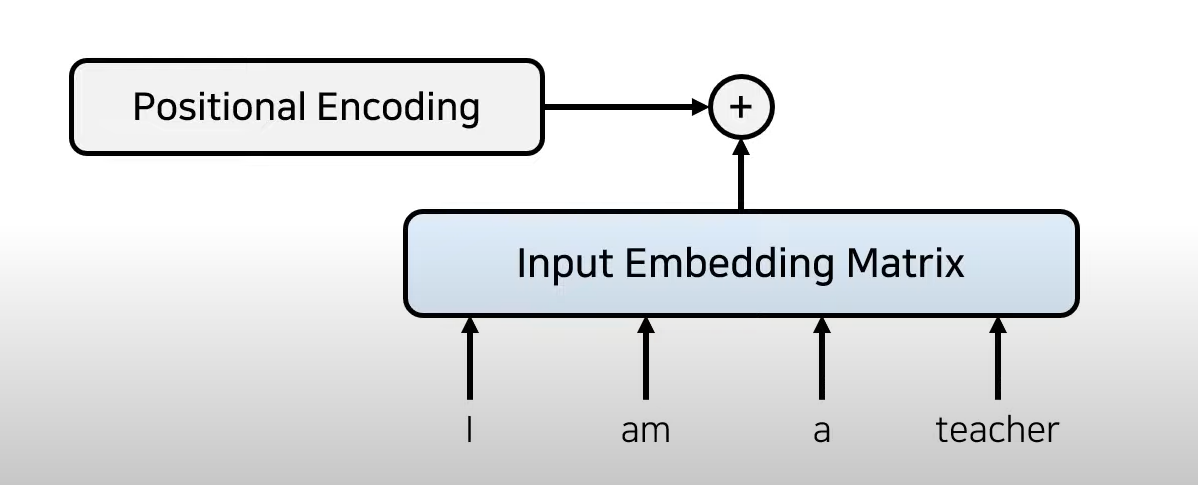

 Sinusoidal Positional Encoding(사인 함수를 사용한 위치 임베딩)

In [5]:
# sinusoid position embedding
import numpy as np
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def cal_angle(position, i_hidn): # position과 임베딩차원(hidn)index 이용해 angle 계산함수
    return position / np.power(10000, 2*(i_hidn//2)/d_hidn)
  def get_pos_angle_vec(position): # 위치에 대한 각도 '벡터'를 반환
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_pos_angle_vec(i_seq) for i_seq in range(n_seq)])
  # 주어진 시퀀스의 길이(n_seq)와 임베딩 차원(d_hidn)에 맞는 테이블을 생성
  # 테이블은 각 위치에 대한 각도 벡터를 포함
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin (0열부터 2씩 건너뒴)
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos (1열부터 2씩 건너뜀)

  return sinusoid_table

In [6]:
n_seq = 64 # input seq 최대 길이
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print(pos_encoding.shape)

(64, 128)


### postition embedding 값 구하기

In [7]:
pos_encoding = torch.FloatTensor(pos_encoding) # 앞서 생성한 것 변환
# 1. 미리 생성한 임베딩테이블을 가지고 Embedding layer 정의
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
                                                     # 학습하는 것이 아니니까 고정시킴
# 2. input 시퀀스의 각 위치에 대한 정보 (position값 구하기)                                                              # 순서유지
positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1

# 3. padded postion 찾고 0으로 값 채우기
pos_mask = inputs.eq(0)
          # 입력 텐서에서 값이 0인 위치를 True로, 나머지를 False로 하는 텐서를 생성
# 패딩된 위치에 대한 정보를 0으로 채움
positions.masked_fill_(pos_mask, 0)

# 4. embedding 값 구하기
pos_embs = nn_pos(positions)

```python
positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
```

여기서 `inputs`는 모델에 입력되는 시퀀스의 텐서를 나타냅니다. 이 텐서의 크기가 `[batch_size, sequence_length]`라고 가정합니다.

- `torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype)`:
  - `inputs.size(1)`은 시퀀스의 길이를 나타냅니다.
  - `torch.arange`는 0부터 인자로 주어진 값까지의 정수를 생성합니다. 따라서 여기서는 0부터 `inputs.size(1)-1`까지의 정수가 생성됩니다.
  - `device=inputs.device` 및 `dtype=inputs.dtype`는 `inputs` 텐서와 동일한 디바이스(device)와 데이터 타입(dtype)을 사용하도록 지정한 것입니다.

- `.expand(inputs.size(0), inputs.size(1)).contiguous()`:
  - `expand` 메서드는 텐서를 복제하고 차원 크기를 확장하는 역할을 합니다. 여기서는 `inputs.size(0)`에 해당하는 배치 차원을 고려하여 텐서를 복제하고 차원을 확장합니다.
  - `contiguous()`는 텐서의 메모리를 연속적으로 배치하는 메서드입니다.

- `+ 1`:
  - 각 위치의 값을 1씩 증가시킵니다. 이는 패딩 토큰을 고려하여 위치 값을 설정하는데 사용됩니다. 패딩 토큰은 보통 0으로 설정되어 있고, 따라서 위치 값을 1부터 시작하도록 1을 더해줍니다.

종합하면, `positions`는 입력 시퀀스의 각 위치에 대한 값을 나타내는 텐서로, 패딩된 위치에 대해서는 0이 아닌 다른 값으로 표현되고, 나머지 위치에는 1부터 시작하는 순차적인 값으로 표현됩니다. 이후에는 이러한 위치 정보를 이용하여 위치 임베딩을 구하는 데 활용됩니다.

In [8]:
print(inputs)
print(positions) # padding 값 0으로 채워진 것 확인 가능!!
print(pos_embs.size()) # input layer와 shape 동일한 것 확인가능!!

tensor([[3225, 3658,  199, 4011, 3811, 3644,    0,    0],
        [ 193, 3660,   54, 3889, 3650, 3736, 3811, 3644]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


In [9]:
input_sums = input_embs + pos_embs

# 3. Scaled Dot Product Attention
-  주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도 구함
- 그런데 self-attention은 k,q,v, 모두 동일
- **즉, 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도**

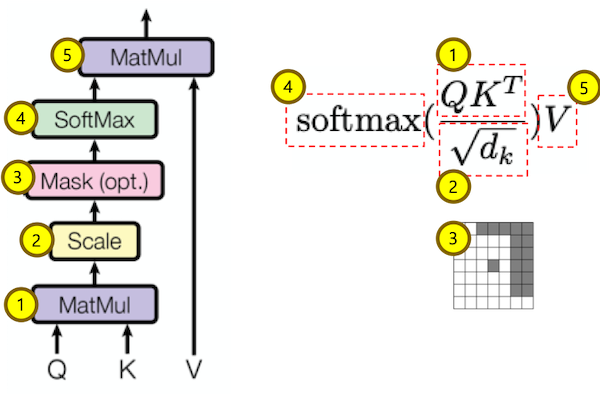

입력값은 Q(query), K(key), V(value) 그리고 attention mask로 구성 되어 있습니다.
입력값 중 K, V는 같은 값 이어야 합니다.
Q, K, V가 모두 동일한 경우는 self attention이라 합니다.

attn_mask는 Attention을 계산할 때, 특정 위치의 단어들을 무시하기 위한 마스크입니다.
특히, 입력 시퀀스에서 패딩된 부분(값이 0인 부분)에 해당하는 위치에 대해 Attention을 수행하지 않도록 합니다.

In [10]:
print(inputs.eq(0))

tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False]])


In [11]:
Q = input_sums
K = input_sums
V = input_sums                              # 배치 크기, Q의 seq 길이, K의 seq 길이
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
          # 값이 "0인 위치에 대해 True", 나머지 위치에 대해 False를 갖는 텐서를 생성
                          # 1번째 차원을 추가하여 행렬을 3D로 만듦 (차원확장)
# 배치 크기 x Query의 시퀀스 길이 x Key의 시퀀스 길이의 크기를 갖게됨

print(attn_mask.size()) # [batch_size, Q_sequence_length, K_sequence_length]
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


MatMul Q, K-transpose (내적/유사도/어텐션스코어)
- 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도(q,k)

transpose(dim0, dim1)은 텐서의 dim0과 dim1 차원을 서로 바꾸는 연산입니다.
-1은 마지막 차원을 나타냅니다.
-2는 끝에서 두 번째 차원을 나타냅니다.

In [12]:
scores = torch.matmul(Q, K.transpose(-1, -2))
                                      # transpose
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[172.1934,  65.1888,  65.6025,  16.1502,  35.0665,  28.5337,  37.4034,
          37.4034],
        [ 65.1888, 157.4758,  69.7404,  68.6054,  48.0115,  43.1579,  64.9680,
          64.9680],
        [ 65.6025,  69.7404, 193.4597,  51.3590,  43.9155,  30.1008,  50.2963,
          50.2963],
        [ 16.1502,  68.6054,  51.3590, 192.5515,  35.9850,  47.0033,  63.8878,
          63.8878],
        [ 35.0665,  48.0115,  43.9155,  35.9850, 176.2411,  61.1840,  32.7208,
          32.7208],
        [ 28.5337,  43.1579,  30.1008,  47.0033,  61.1840, 170.8165,  39.8207,
          39.8207],
        [ 37.4034,  64.9680,  50.2963,  63.8878,  32.7208,  39.8207, 173.8346,
         173.8346],
        [ 37.4034,  64.9680,  50.2963,  63.8878,  32.7208,  39.8207, 173.8346,
         173.8346]], grad_fn=<SelectBackward0>)


scale : k-dimension에 루트를 취해 나눔
- Q,K,V 벡터의 차원**(논문에서는 64 = d model(512) / num_heads(8) )**

In [13]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size()) # 가중치 편차가 줄어듦
print(scores[0])

torch.Size([2, 8, 8])
tensor([[21.5242,  8.1486,  8.2003,  2.0188,  4.3833,  3.5667,  4.6754,  4.6754],
        [ 8.1486, 19.6845,  8.7175,  8.5757,  6.0014,  5.3947,  8.1210,  8.1210],
        [ 8.2003,  8.7175, 24.1825,  6.4199,  5.4894,  3.7626,  6.2870,  6.2870],
        [ 2.0188,  8.5757,  6.4199, 24.0689,  4.4981,  5.8754,  7.9860,  7.9860],
        [ 4.3833,  6.0014,  5.4894,  4.4981, 22.0301,  7.6480,  4.0901,  4.0901],
        [ 3.5667,  5.3947,  3.7626,  5.8754,  7.6480, 21.3521,  4.9776,  4.9776],
        [ 4.6754,  8.1210,  6.2870,  7.9860,  4.0901,  4.9776, 21.7293, 21.7293],
        [ 4.6754,  8.1210,  6.2870,  7.9860,  4.0901,  4.9776, 21.7293, 21.7293]],
       grad_fn=<SelectBackward0>)


Mask (Opt.)

In [14]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 2.1524e+01,  8.1486e+00,  8.2003e+00,  2.0188e+00,  4.3833e+00,
          3.5667e+00, -1.0000e+09, -1.0000e+09],
        [ 8.1486e+00,  1.9684e+01,  8.7175e+00,  8.5757e+00,  6.0014e+00,
          5.3947e+00, -1.0000e+09, -1.0000e+09],
        [ 8.2003e+00,  8.7175e+00,  2.4182e+01,  6.4199e+00,  5.4894e+00,
          3.7626e+00, -1.0000e+09, -1.0000e+09],
        [ 2.0188e+00,  8.5757e+00,  6.4199e+00,  2.4069e+01,  4.4981e+00,
          5.8754e+00, -1.0000e+09, -1.0000e+09],
        [ 4.3833e+00,  6.0014e+00,  5.4894e+00,  4.4981e+00,  2.2030e+01,
          7.6480e+00, -1.0000e+09, -1.0000e+09],
        [ 3.5667e+00,  5.3947e+00,  3.7626e+00,  5.8754e+00,  7.6480e+00,
          2.1352e+01, -1.0000e+09, -1.0000e+09],
        [ 4.6754e+00,  8.1210e+00,  6.2870e+00,  7.9860e+00,  4.0901e+00,
          4.9776e+00, -1.0000e+09, -1.0000e+09],
        [ 4.6754e+00,  8.1210e+00,  6.2870e+00,  7.9860e+00,  4.0901e+00,
          4.9776e+00, -1.0000e+09, -1.0000e

Softmax

In [15]:
print()

In [16]:
attn_prob = nn.Softmax(dim=-1)(scores)
                      # 마지막 차원에 대해 계산
print(attn_prob.size()) # mask한 부분은 0이 된 것 확인!!
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 1.5526e-06, 1.6350e-06, 3.3800e-09, 3.5960e-08, 1.5892e-08,
         0.0000e+00, 0.0000e+00],
        [9.7728e-06, 9.9996e-01, 1.7263e-05, 1.4979e-05, 1.1416e-06, 6.2234e-07,
         0.0000e+00, 0.0000e+00],
        [1.1456e-07, 1.9217e-07, 1.0000e+00, 1.9311e-08, 7.6159e-09, 1.3545e-09,
         0.0000e+00, 0.0000e+00],
        [2.6530e-10, 1.8679e-07, 2.1633e-08, 1.0000e+00, 3.1659e-09, 1.2550e-08,
         0.0000e+00, 0.0000e+00],
        [2.1681e-08, 1.0935e-07, 6.5534e-08, 2.4319e-08, 1.0000e+00, 5.6744e-07,
         0.0000e+00, 0.0000e+00],
        [1.8876e-08, 1.1744e-07, 2.2961e-08, 1.8992e-07, 1.1179e-06, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4996e-02, 4.7031e-01, 7.5145e-02, 4.1091e-01, 8.3519e-03, 2.0287e-02,
         0.0000e+00, 0.0000e+00],
        [1.4996e-02, 4.7031e-01, 7.5145e-02, 4.1091e-01, 8.3519e-03, 2.0287e-02,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward0>)


# 왜 마지막 차원에서 softmax를 게산?

MatMul attn_prov, V

In [17]:
context = torch.matmul(attn_prob, V)
print(context.size()) # 차원 맞춰짐

torch.Size([2, 8, 128])


In [18]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)

    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

# 3. Multi-Head Attention

[Multi-Head Attention]

Multi-Head Attention은 scaled Dot-Product Attention을 query에 해당하는 value 값들을 참조하기 위해 사용하는데, query, key, value를 그대로 사용하는 것이 아니라, 여러 개의 head로 나누고, query, key, value를 linear projection 한 후, 사용한다.
Scaled Dot-Product Attention 이후, 각 head의 value 값을 concat하고, linear layer을 거쳐 output을 낸다.
주의할 점은, sequence의 순서가 중요하기 때문에, contiguous를 사용해서, 순서를 유지한다는 점이다.

멀티 헤드 어텐션은 전체 어텐션을 분리하여 병렬적으로 어텐션을 수행하는 기법입니다.
즉 (batch_size, 50, 648) 의 텐서가 있다면 이것을 (batch_size, 50, 64) 의 8개의 텐서로 나눈다음에 개별적으로 어텐션을 수행하고, 다시 (batch_size, 50, 648)의 텐서로 concat(합치는) 하게 됩니다.
이렇게 하는 이유는, 깊은 차원을 한번에 어텐션을 수행하는 것보다, 병렬로 각각 수행하는 것이 더 심도있는 언어들간의 관계를 학습할 수 있기 때문입니다.

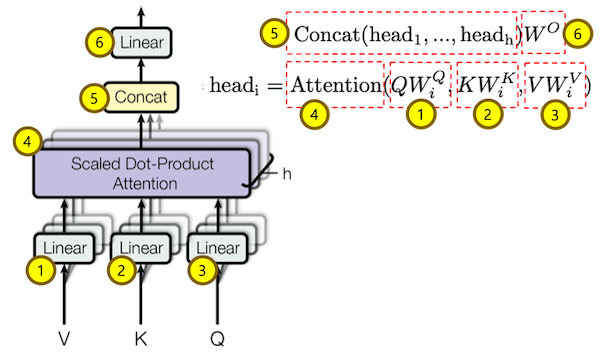

Multi Head Q, K, V ; Q를 여러개의 head로 나눔

 원래 q_s의 shape는 (batch_size, n_seq, n_head * d_head)로, 각 시퀀스 위치에 대해 n_head * d_head의 차원이 있습니다. 이를 (batch_size, n_seq, n_head, d_head)로 변환하면 각 시퀀스 위치에 대해 n_head개의 Head가 있고, 각 Head는 d_head 차원을 가지게 됩니다.

In [19]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

# 가중치 행렬
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# 가중치 행렬과의 곱
# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(q_s.size())

# (bs, n_seq, n_head, d_head)
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())

# (bs, n_head, n_seq, d_head) - 각 Head에 대한 Query
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [20]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


In [21]:
# attention mask도 multi-head로 변경
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
                                        # 1이면 유지해라라는 뜻!
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


In [22]:
# attention
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


The view(-1) operation flattens the tensor, if it wasn’t already flattened as seen here:

x = torch.randn(2, 3, 4)
print(x.shape)
> torch.Size([2, 3, 4])
x = x.view(-1)
print(x.shape)
> torch.Size([24])
It’ll modify the tensor metadata and will not create a copy of it.

알아서 변경 전후 shape 동일하게 값 들어갈거임

In [23]:
# concat
# 원래 (bs, n_head, n_seq, d_head)
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head*d_head)
print(context.size())

torch.Size([2, 8, 128])


In [24]:
# linear
linear = nn.Linear(n_head * d_head, d_hidn)
                  # d-input,         d-output
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size()) # 입력 Q와 동일한 shape

torch.Size([2, 8, 128])


d_hidn: Hidden 차원의 크기입니다. 이는 Attention 연산 후에 나오는 출력의 Hidden 차원의 크기입니다.

n_head: Head의 개수입니다. Multi-Head Attention에서 Head를 몇 개 사용할지를 결정합니다.

d_head: 각 Head의 Hidden 차원의 크기입니다. 즉, 하나의 Head의 Hidden 차원의 크기입니다.

In [25]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

# 5. Feed Forward
(Pointwise Feed Forward 네트워크에서는 인코더의 출력에서 512개의 차원이 2048차원까지 확장되고,
다시 512개의 차원으로 압축됩니다.)

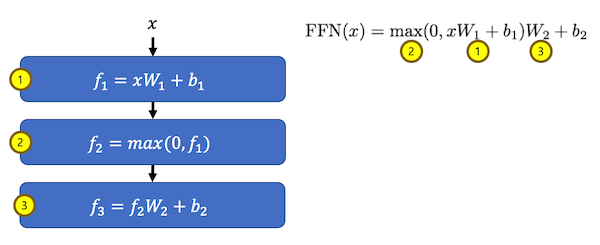

f1 (Linear) - f2 (Actiavtion) - f3 (Linear)

커널 크기는 Convolutional Neural Network (CNN)에서 사용되는 필터의 크기를 나타냅니다. 이것은 주로 텍스트나 이미지와 같은 다양한 데이터에서 특징을 추출하는 데 사용됩니다.

여기서 주어진 코드에서는 `nn.Conv1d`에서 `kernel_size=1`로 설정되어 있습니다. 이것은 1D Convolution을 수행할 때, 사용되는 필터의 크기가 1이라는 뜻입니다. 즉, 각 위치의 픽셀이나 단어 등이 개별적으로 처리됩니다. 이렇게 작은 커널 크기는 주로 선형 변환을 수행하는데 활용되며, 특별한 특징을 감지하거나 패턴을 학습하는 데 사용될 수 있습니다.

커널 크기가 1인 경우, 각 입력 위치는 독립적으로 처리되며, 이는 전형적인 선형 변환과 같은 역할을 합니다. 더 큰 커널 크기는 지역적인 특징이나 관계를 캡처할 수 있도록 도와줍니다.

f1

In [26]:
# f1 : 1D Convolution - 선형 변환, 출력 차원 조절
conv1 = nn.Conv1d(in_channels = d_hidn, out_channels = d_hidn*4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1,2)) # output, 이 전 layer 결과(multi-head attention)
print(ff_1.size())

torch.Size([2, 512, 8])


f2
- Activation (relu or gelu) 과정 입니다.
논문이 발표 될 당시는 relu를 사용하도록 되어 있었지만 이후 gelu를 사용할 때 더 성능이 좋다는 것이 발견되었습니다.

In [27]:
import torch.nn.functional as F
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

f3

In [28]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


In [29]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

# 6. Masked Multi-head Attention

지금까지 임베딩 -> 멀티 헤드 어텐션 -> 포인트와이즈 피드 포워드 네트워크까지 살펴 보았습니다.
트랜스포머에서의 인코딩은 (멀티헤드어텐션 + 포인트와이즈 피드 포워드 네트워크)를 층층이 쌓은 것입니다. 따라서 방금 공부했던 멀티헤드 어텐션과 포인트와이즈 피드 포워드 네트워크를 겹겹이 쌓아서, 인코더층을 쌓는 것입니다.

인코더 레이어를 정의해서 멀티헤드 어텐션과 포인트와이즈 피드 포워드 네트워크를 합쳐 보도록 하겠습니다.

단어 임베딩 벡터(단어 임베딩+위치 임베딩)가 -> 1. 멀티헤드어텐션 -> 2. Residual Network를 거쳐 원래 input과 멀티헤드어텐션의 합이 출력 -> 3. 포인트와이즈 피드포워드 네트워크 를 거치고, -> 4. Residual Network를 거쳐서 원래의 인풋과 포인트와이즈 피드포워드 네트워크의 합이 출력됨

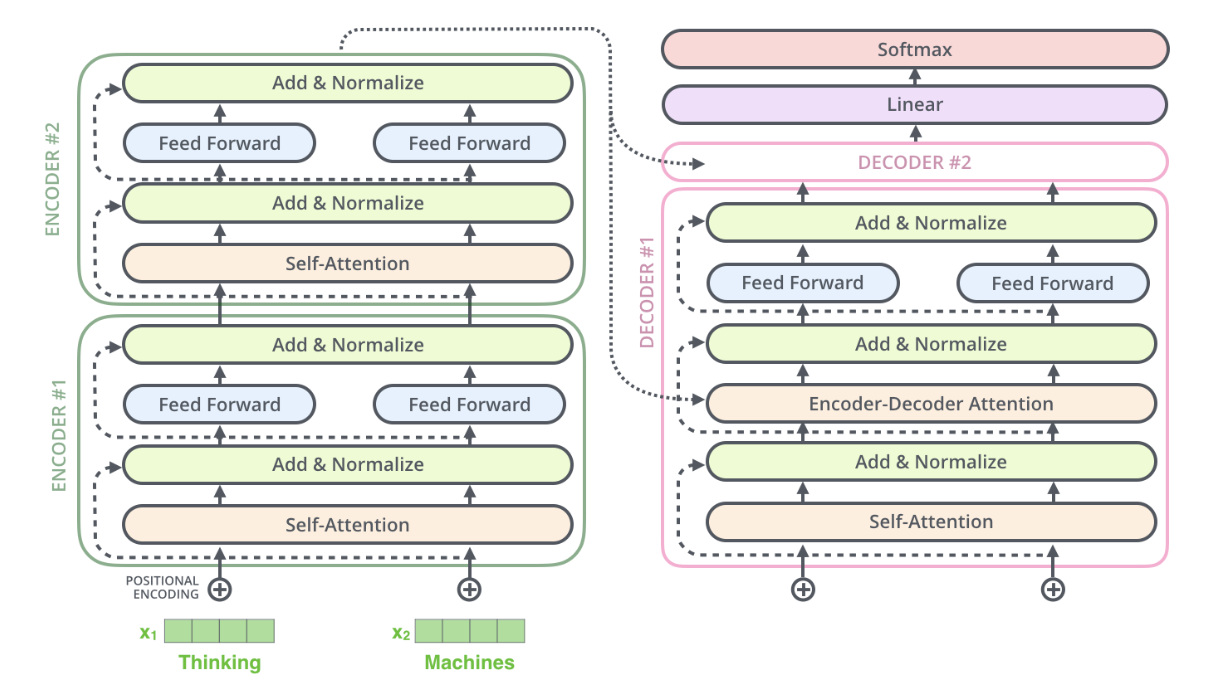


# Encoder Layer
1. Multi-Head Attention을 수행합니다. (줄: 14)
Q, K, V 모두 동일한 값을 사용하는 self-attention 입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 15)
3. 2번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 17)
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 18)Text fett markieren

```python
# encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob
```

디코더는 인코더랑 유사하지만, 구조가 약간 다릅니다. 이번 Seq2Seq는 포르투갈어를 영어로 바꾸는 문제입니다. 디코더에서는 두단계의 멀티 헤드 어텐션 구조를 거치는데, 첫번째 멀티 헤드 어텐션은, 영어문장과 영어문장의 셀프 어텐션을 하여, 영어 문장간의 관계를 배우게 됩니다.
두번째 멀티 헤드 어텐션은 포르투갈어가 인코딩 된 것과, 영어 문장간의 셀프 어텐션된 결과를 다시 어텐션 해서 포르투갈 어와 영어의 관계를 학습하게 됩니다.

포르투갈어가 암호화된 것과, 영어 문장 한단어 한단어를 보면서 다음 단어를 예측하게 되기 때문에, look_ahead_mask를 사용하게 됩니다.
만약 영어 문장이 (I love you) 로 이루어져 있다면, look_ahead_mask를 사용하면,
(I, 0, 0) -> Love 예측, (I love, 0) -> You 예측, (I love you) -> 단어의 끝인 [SEP] 예측을 합니다.
즉 look_ahead_mask는 다음 단어를 예측할 때, 전에 있던 단어만으로 예측할수 있도록 앞에 있는 단어는 가리는 것입니다.

이러한 역할을 가능하게 하는 mask가 look_ahead_mask 입니다.

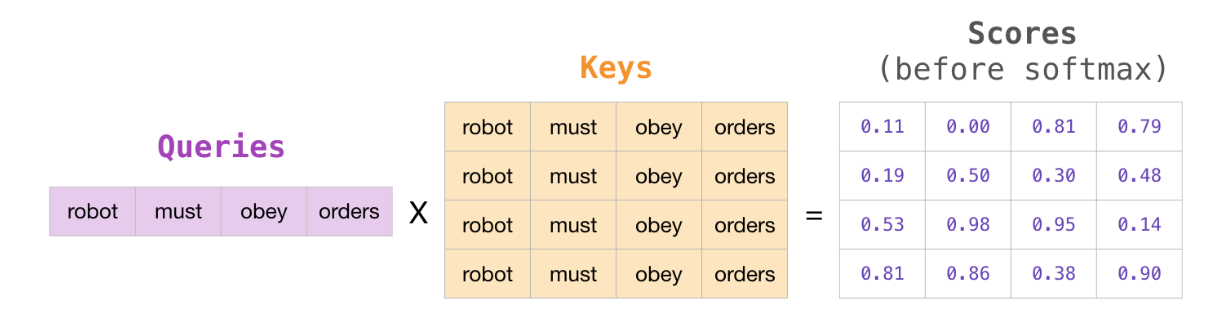

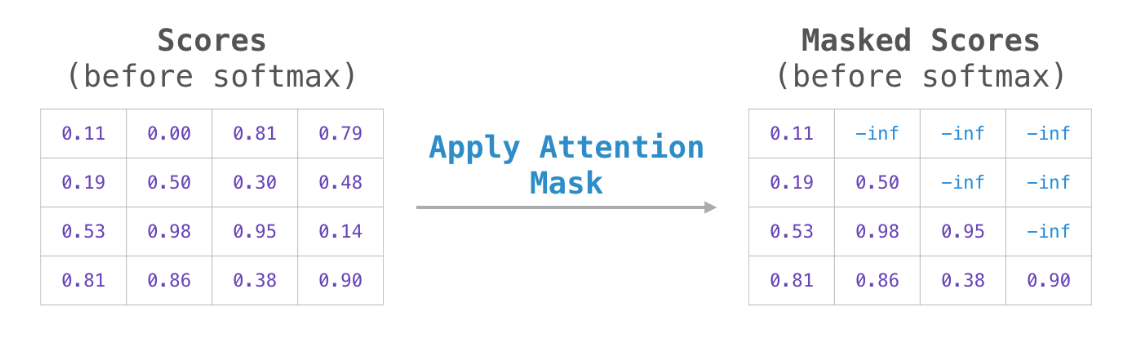

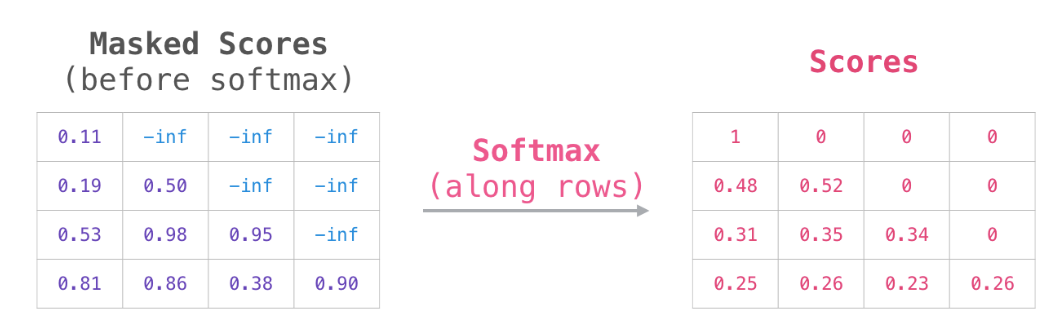

In [32]:
print(inputs.shape)

torch.Size([2, 8])


In [33]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
  # 주어진 seq과 같은 shape인데 1로 채워짐
                                          # 마지막 차원 추가, 2 8 8 (3d) (bc,n_seq)
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

Q = input_sums
K = input_sums
V = input_sums

# encoder와 동일
attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
                # 값이 "0인 위치에 대해 True", 나머지 위치에 대해 False를 갖는 텐서를 생성
                               # 1번째 차원을 추가하여 행렬을 3D로 만듦 (차원확장)
# 배치 크기 x Query의 시퀀스 길이 x Key의 시퀀스 길이의 크기를 갖게됨
print(attn_pad_mask[1])

attn_dec_mask = get_attn_decoder_mask(inputs)
# print(attn_dec_mask.shape)
print(attn_dec_mask[1])

# 두 mask 과정 더하고, 결과가 0보다 큰지 확인하여(gt, greater than) 최종 attention mask 생성
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
torch.Size([2, 8, 8])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True, 

Multi-Head Attention은 동일

In [34]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
# attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
                                        # 1이면 유지해라라는 뜻!
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


# Decoder Layer

1. Multi-Head Attention을 수행합니다. (줄: 16)
Q, K, V 모두 동일한 값을 사용하는 self-attention 입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 17)
3. Encoder-Decoder Multi-Head Attention을 수행합니다. (줄: 19)
- Q: 2번의 결과
- K, V: Encoder 결과
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 20)
5. 4번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 22)
6. 5번의 결과와 4번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 23)

```python
# decoder layer (decoder가 for문 돌면서 layer거침)
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):

        #### 첫번째 멀티 헤드 어텐션은, 인코더와의 결합 없이 output 될 문장끼리만 어텐션을 함 ####
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)

        #### 두번째 멀티 헤드 어텐션 파트는 인코더 아웃풋과 위의 아웃풋
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob
```

# Decoder

1. 입력에 대한 Position 값을 구합니다. (줄: 14~16)
2. Input Embedding과 Position Embedding을 구한 후 더합니다. (줄: 19)
3. 입력에 대한 attention pad mask를 구합니다. (줄: 22)
4. 입력에 대한 decoder attention mask를 구합니다. (줄: 24)
5. attention pad mask와 decoder attention mask 중 1곳이라도 mask되어 있는 부분인 mask 되도록 attention mask를 구합니다. (줄: 26)
6. Q(decoder input), K(encoder output)에 대한 attention mask를 구합니다. (줄: 28)
- 디코더의 self-attention에서는 dec_inputs을 두 번 사용하여 자기 자신에 대한 마스크를 만들고, encoder-decoder attention에서는 dec_inputs과 enc_inputs을 함께 사용하여 패딩된 부분을 구분하는 마스크를 만듭니다.
7. for 루프를 돌며 각 layer를 실행합니다. (줄: 27)
layer의 입력은 이전 layer의 출력 값 입니다.

```python
# decoder
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad) # 28

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs
```

In [35]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)

    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs) # 12
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs) # 14
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs